In [1]:
# Load all neccessary packages
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch import optim
from torch.utils.data import DataLoader, random_split, TensorDataset, ConcatDataset

Load the dataset and data preprocessing

In [2]:
# Transformation pipeline: Converts grayscale image to tensor and normalizes pixels to [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Define batch size
BATCH_SIZE = 64

# Load the MNIST training dataset with transformations
train_dataset = datasets.MNIST(root = '.data', train = True, transform = transform, download = True)
test_dataset = datasets.MNIST(root = '.data', train = False, transform = transform, download = True)

# Split the training dataset into training (80%) and validation (20%) datasets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create a DataLoader for the new training and validation datasets
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Create a DataLoader for the testing dataset
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle=False)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:11<00:00, 897kB/s] 


Extracting .data/MNIST/raw/train-images-idx3-ubyte.gz to .data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]


Extracting .data/MNIST/raw/train-labels-idx1-ubyte.gz to .data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]


Extracting .data/MNIST/raw/t10k-images-idx3-ubyte.gz to .data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.51MB/s]

Extracting .data/MNIST/raw/t10k-labels-idx1-ubyte.gz to .data/MNIST/raw



Print information to understand the MNIST dataset

In [3]:
print("size of train dataset:", len(train_dataset))
print("size of validation dataset:", len(val_dataset))

size of train dataset: 48000
size of validation dataset: 12000


samples in Training Dataset: 48000
length of Validation Dataset: 12000
samples in Test Dataset: 10000
Training Dataset Samples:


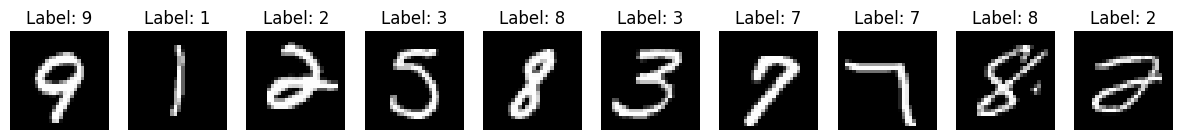

Validation Dataset Samples:


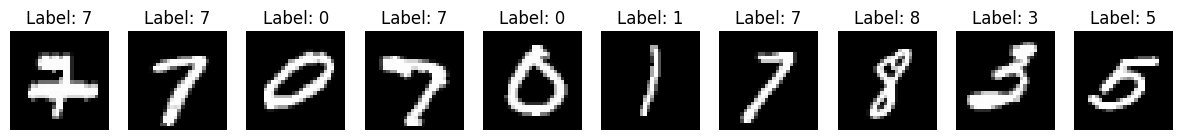

Test Dataset Samples:


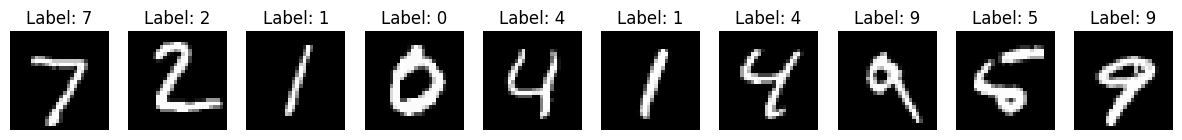

In [4]:
# Print the numner of samples in each dataset
print(f"samples in Training Dataset: {len(train_dataset)}")
print(f"length of Validation Dataset: {len(val_dataset)}")
print(f"samples in Test Dataset: {len(test_dataset)}")

# Function to display 10 samples and their corresponding labels
def show_images_and_labels(dataset, num_images=10):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        image, label = dataset[i]
        plt.subplot(5, 10, i + 1)
        plt.imshow(image.squeeze(), cmap="gray")
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.show()

# Display 10 random samples from the training dataset
print("Training Dataset Samples:")
show_images_and_labels(train_dataset)

# Display 10 random samples from the validation dataset
print("Validation Dataset Samples:")
show_images_and_labels(val_dataset)

# Display 10 random samples from the test dataset
print("Test Dataset Samples:")
show_images_and_labels(test_dataset)


### Task 1: CNN implementation in PyTorch

In [5]:
 # Define a CNN model on MNIST

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1) # First convolutional layer configure
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # Reduces spatial dimensions by half (2x2 pool size)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1) # Second convolutional layer configure
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Fully connected layer
        self.dropout = nn.Dropout(p=0.2) # Dropout layer to prevent overfitting (20% dropout rate)
        self.fc2 = nn.Linear(128, 64) # Fully connected layer
        self.fc3 = nn.Linear(64, 10) # Output layer: 64 neurons -> 10 output classes (digits 0-9)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # pass output from conv1 to the relu activation function, then go through the max pool layer
        x = self.pool(F.relu(self.conv2(x))) # Apply second convolution, ReLU activation, and max pooling
        x = x.view(x.size(0), -1) # Flatten the tensor for fully connected layers
        x = F.relu(self.fc1(x))   # Fully connected layer with ReLU activation
        x = self.dropout(x)   # Apply dropout to reduce overfitting
        x = F.relu(self.fc2(x))  # Second fully connected layer with ReLU activation
        x = self.fc3(x)    # Output layer (logits for 10 classes)

        return x


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
# Function to train the model
def train_model(model, train_loader, val_loader, optimizer, num_epochs, model_save_path):
    best_val_loss = float('inf')

    # going through the entire training dataset for num_epochs times
    for epoch in range(num_epochs):
        model.train() # set model in training mode
        train_loss = 0.0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()  # reset gradients
            output = model(data)
            loss = criterion(output, target) # compute loss between output and target
            loss.backward()  # calculate gradient per batch of data
            optimizer.step() # update model parameters per batch of data
            train_loss += loss.item()

        #after each epoch of training, run the current trained model on the validation set to see accuracy:
        val_loss = 0.0
        model.eval()  # set model in evaluation model
        with torch.no_grad():  # no gradient calculation, no parameters updates here
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                val_loss += loss.item()


        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader) # calculate the accuracy of the model on validation set
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}")


        if avg_val_loss < best_val_loss: # save the model if average loss is less then the best validation loss
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), model_save_path)
            print(f"Model saved at Epoch {epoch+1}")

model_save_path = 'best_model.pth'
train_model(model, train_loader, val_loader, optimizer, num_epochs=10, model_save_path=model_save_path)

Epoch 1/10, Training Loss: 0.2504377052622537, Validation Loss: 0.06973080186822274
Model saved at Epoch 1
Epoch 2/10, Training Loss: 0.06624517368944362, Validation Loss: 0.04675027727461519
Model saved at Epoch 2
Epoch 3/10, Training Loss: 0.048068220080652584, Validation Loss: 0.0474027203242084
Epoch 4/10, Training Loss: 0.03732268627453596, Validation Loss: 0.04174103423986495
Model saved at Epoch 4
Epoch 5/10, Training Loss: 0.030057739361693772, Validation Loss: 0.04785928130387858
Epoch 6/10, Training Loss: 0.024734788268416498, Validation Loss: 0.037370951144963485
Model saved at Epoch 6
Epoch 7/10, Training Loss: 0.023026938886895852, Validation Loss: 0.037391591343332545
Epoch 8/10, Training Loss: 0.019670795657322743, Validation Loss: 0.038941718547816216
Epoch 9/10, Training Loss: 0.017032055601287236, Validation Loss: 0.04925809048682929
Epoch 10/10, Training Loss: 0.01386408906523502, Validation Loss: 0.037204822431263856
Model saved at Epoch 10


In [8]:
# test the training model on test dataset
def test_model(model, test_loader, num_samples=100):
    model.eval()
    test_loss = 0.0
    correct = 0
    sample_count = 0

    with torch.no_grad(): # do not update parameters during evaluation
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

            if sample_count < num_samples:
                print("\nSample predictions:")
                for i in range(data.size(0)):
                    if sample_count >= num_samples:
                        break
                    print(f"Sample {sample_count + 1}:")
                    print(f"  True label: {target[i].item()}")
                    print(f"  Predicted raw output: {output[i]}")
                    print(f"  Predicted label: {pred[i].item()}")
                    sample_count += 1

    avg_test_loss = test_loss / len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)
    print(f"\nTest Loss: {avg_test_loss}, Accuracy: {accuracy}")


In [9]:
# test the saved model on test dataset
def load_and_test_model(model, model_load_path, test_loader):
    model.load_state_dict(torch.load(model_load_path))
    model.to(device)
    test_model(model, test_loader)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)

model_load_path = 'best_model.pth'
load_and_test_model(model, model_load_path, test_loader)

<ipython-input-9-c638b1f39f62>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_load_path))



Sample predictions:
Sample 1:
  True label: 7
  Predicted raw output: tensor([-14.1739,  -5.5333,  -3.8687,  -6.0154,  -1.3167, -12.8462, -26.2425,
         22.3921, -12.9784,  -1.3149], device='cuda:0')
  Predicted label: 7
Sample 2:
  True label: 2
  Predicted raw output: tensor([ -1.8642,   2.7937,  21.5423,  -8.7360,  -4.3376, -19.2466,  -6.8334,
         -2.3465, -13.5195, -12.4155], device='cuda:0')
  Predicted label: 2
Sample 3:
  True label: 1
  Predicted raw output: tensor([-10.7379,  18.8054,  -6.0613, -14.8987,  -4.4218,  -9.4059,  -4.6977,
         -4.1425,  -5.7707, -11.3947], device='cuda:0')
  Predicted label: 1
Sample 4:
  True label: 0
  Predicted raw output: tensor([ 20.4780, -10.9605, -10.7098, -16.7383,  -7.7666, -11.5719,  -4.5077,
         -9.5803,  -7.1557,  -4.6377], device='cuda:0')
  Predicted label: 0
Sample 5:
  True label: 4
  Predicted raw output: tensor([-7.9942e+00, -9.1194e+00, -9.2343e+00, -1.6043e+01,  1.2679e+01,
        -8.4989e+00, -9.4132e+00, -6

### Task 2: Add Gaussian noises

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.58MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.09MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.14MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



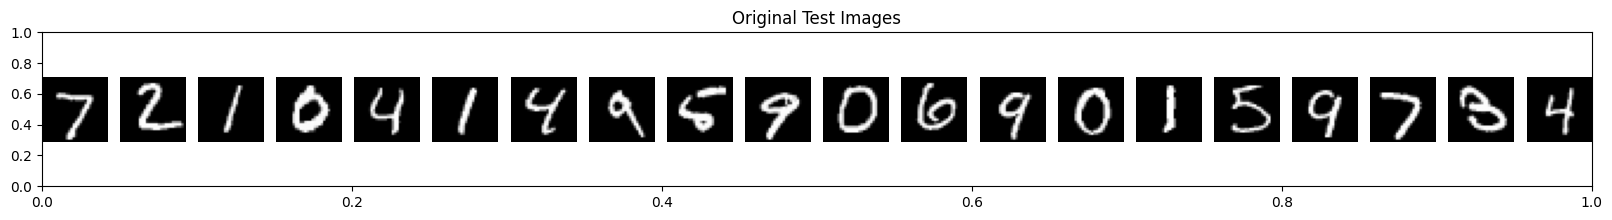

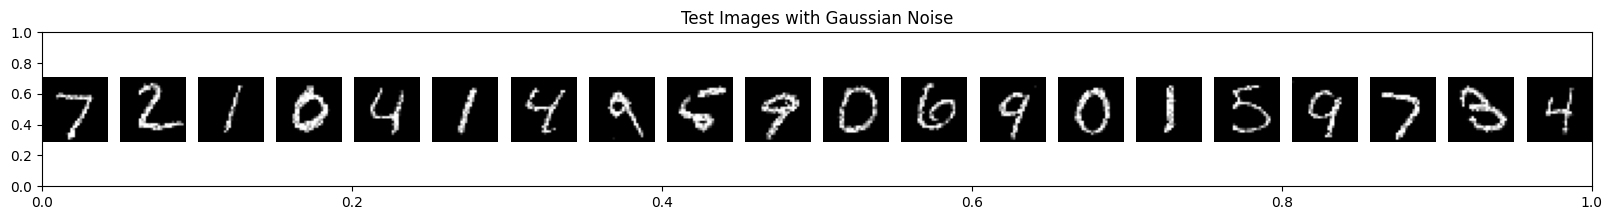

In [10]:
def add_gaussian_noise(img, mean=0., std=1.):
    noise = torch.randn(img.size()) * std + mean
    noisy_img = img + noise
    return noisy_img.clamp(0, 1)


transform_with_noise = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.Lambda(lambda x: add_gaussian_noise(x, std=0.3)) # adjust level of noise: change std to see difference
])


# add noise to datasets:
test_dataset_with_noise = datasets.MNIST('./data', train=False, transform=transform_with_noise, download=True)
test_loader_with_noise = DataLoader(test_dataset_with_noise, batch_size=BATCH_SIZE, shuffle=False)


def show_images(dataset, idxs, title):
    plt.figure(figsize=(20, 2))
    plt.title(title)
    for i, idx in enumerate(idxs):
        ax = plt.subplot(1, len(idxs), i + 1)
        plt.imshow(dataset[idx][0].squeeze(), cmap='gray')
        plt.axis('off')
    plt.show()

idxs = range(20)
show_images(test_dataset, idxs, "Original Test Images")
show_images(test_dataset_with_noise, idxs, "Test Images with Gaussian Noise")


In [11]:
# Performance after adding guassian noise to test dataset
load_and_test_model(model, model_load_path, test_loader_with_noise)

<ipython-input-9-c638b1f39f62>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_load_path))



Sample predictions:
Sample 1:
  True label: 7
  Predicted raw output: tensor([ -7.6062,  -1.8529,  -1.6651,  -1.3686,  -1.0161,  -6.0220, -12.7543,
         10.9087,  -5.4473,  -1.5956], device='cuda:0')
  Predicted label: 7
Sample 2:
  True label: 2
  Predicted raw output: tensor([-0.8681, -0.8393,  9.7318, -2.4710, -2.8262, -6.4479, -1.6430, -2.7944,
        -4.3020, -6.0569], device='cuda:0')
  Predicted label: 2
Sample 3:
  True label: 1
  Predicted raw output: tensor([-2.6266,  3.4196, -1.8193, -3.1135, -0.3126, -2.0122, -2.7871,  0.6213,
         0.4032, -2.1043], device='cuda:0')
  Predicted label: 1
Sample 4:
  True label: 0
  Predicted raw output: tensor([ 7.3242, -4.6387, -3.1586, -5.4449, -3.6749, -3.3391, -1.2389, -4.4260,
        -2.2558, -3.0269], device='cuda:0')
  Predicted label: 0
Sample 5:
  True label: 4
  Predicted raw output: tensor([-3.5051, -2.0880, -1.8996, -5.1211,  3.0614, -3.1929, -2.7287, -1.7378,
        -2.1921,  0.0179], device='cuda:0')
  Predicted lab

### Task 3: Add FGSM (Fast Gradient Sign Method) noises

Fast Gradient Sign Method (FGSM) Attack

The **Fast Gradient Sign Method (FGSM)** attack aims to reduce the accuracy of a machine learning model by introducing **carefully crafted perturbations** to the input data. It utilizes the **gradients of the model’s loss function** with respect to the input data to generate adversarial examples.

$$
x' = x + \epsilon \cdot \text{sign}(\nabla_x J(\theta, x, y))
$$

where:

\begin{aligned}
&x' \quad \text{is the adversarial image}, \\
&x \quad \text{is the original input}, \\
&\epsilon \quad \text{controls the attack strength}, \\
&J(\theta, x, y) \quad \text{is the model’s loss function}, \\
&\nabla_x J \quad \text{represents the gradient of the loss w.r.t. input}.
\end{aligned}


FGSM is effective because it **exploits the linearity of the gradients**. By taking the **sign** of the gradient, the attack **maximizes the loss function in the direction that misleads the model**. The perturbation \( $\epsilon$ \) determines the balance between keeping the adversarial image visually similar to the original and significantly affecting the model’s predictions.

In [12]:
# FGSM Attack function
def fgsm_attack(image, epsilon, gradient):
    perturbed_image = image + epsilon * gradient.sign() # Generates an adversarial example using FGSM attack.
    return torch.clamp(perturbed_image, 0, 1)  # Keep pixel values within valid range

# Generate FGSM-perturbed dataset
def generate_fgsm_dataset(model, device, test_loader, epsilon): # Creates a dataset of FGSM adversarial examples from the test dataset.
    model.eval()
    adversarial_images = []
    adversarial_labels = []

    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        images.requires_grad = True  # Enable gradients for attack

        outputs = model(images)
        loss = criterion(outputs, labels)

        model.zero_grad()
        loss.backward()

        perturbed_images = fgsm_attack(images, epsilon, images.grad.data)

        adversarial_images.extend(perturbed_images.detach().cpu())
        adversarial_labels.extend(labels.cpu())

    return torch.stack(adversarial_images), torch.tensor(adversarial_labels)  # Return tensors

# Define FGSM attack strength
epsilon = 0.25

# Generate adversarial dataset
fgsm_images, fgsm_labels = generate_fgsm_dataset(model, device, test_loader, epsilon)

# Create FGSM test dataset and DataLoader
test_dataset_fgsm = TensorDataset(fgsm_images, fgsm_labels)
test_loader_fgsm = DataLoader(test_dataset_fgsm, batch_size=BATCH_SIZE, shuffle=False)

In [13]:
# Verify the number of samples in FGSM test dataset
print(f"Total samples in FGSM test dataset: {len(test_dataset_fgsm)}")

Total samples in FGSM test dataset: 10000


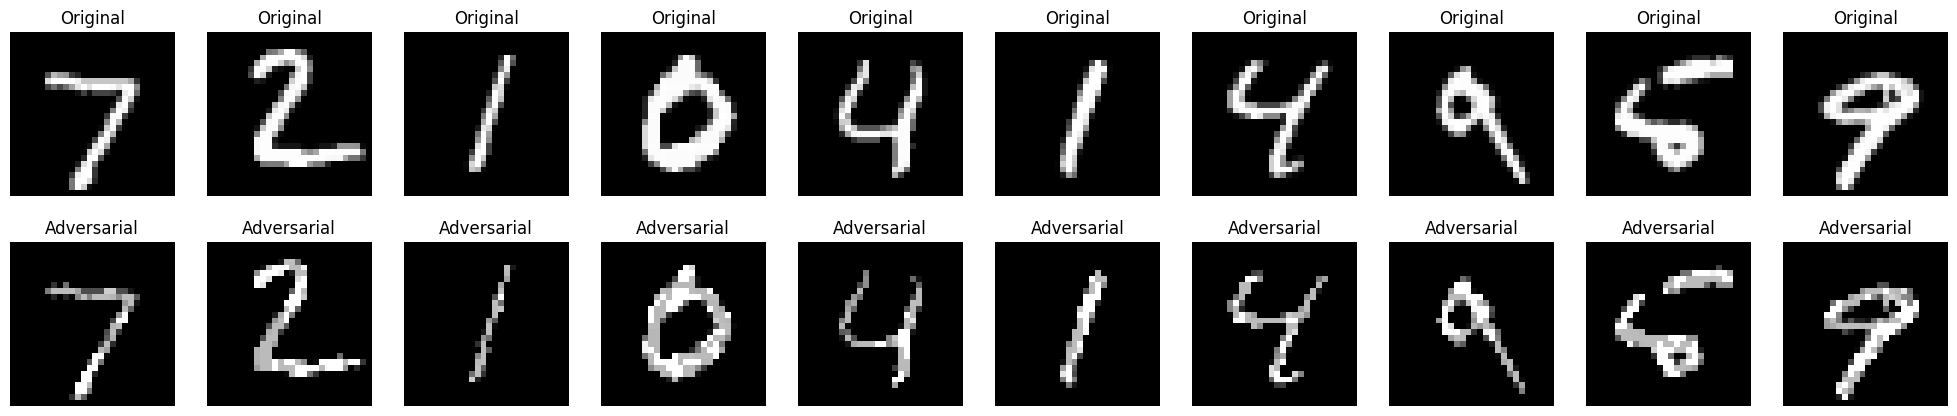

In [14]:
# Displays original and FGSM-perturbed images side by side.
def visualize_comparison(original_images, adversarial_images, title1, title2, num_images=10):
    plt.figure(figsize=(25, 5))

    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original_images[i].squeeze(), cmap='gray')
        plt.title(title1)
        plt.axis('off')

        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(adversarial_images[i].squeeze(), cmap='gray')
        plt.title(title2)
        plt.axis('off')

    plt.show()

# Get original images for comparison
original_samples = [test_dataset[i][0] for i in range(10)]
adversarial_samples = [test_dataset_fgsm[i][0] for i in range(10)]

# Display original vs. FGSM images
visualize_comparison(original_samples, adversarial_samples, "Original", "Adversarial", num_images=10)

In [15]:
# performance of model after the fsgm noise added
load_and_test_model(model, model_load_path, test_loader_fgsm)

<ipython-input-9-c638b1f39f62>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_load_path))



Sample predictions:
Sample 1:
  True label: 7
  Predicted raw output: tensor([ -7.4871,  -2.0091,  -1.5169,  -1.3371,  -0.6641,  -6.2442, -12.3079,
         10.3954,  -5.7214,  -0.7929], device='cuda:0')
  Predicted label: 7
Sample 2:
  True label: 2
  Predicted raw output: tensor([-2.3392,  1.6507,  9.7420, -2.5088, -2.3337, -7.4544, -2.4541, -1.3737,
        -5.4045, -6.0542], device='cuda:0')
  Predicted label: 2
Sample 3:
  True label: 1
  Predicted raw output: tensor([-2.5750,  2.7567, -1.4214, -2.2422, -0.1331, -1.8121, -2.3350,  0.8572,
        -0.0778, -1.9778], device='cuda:0')
  Predicted label: 1
Sample 4:
  True label: 0
  Predicted raw output: tensor([ 4.8157, -3.3211, -2.7218, -3.8859, -2.6876, -2.1939, -0.2873, -3.4620,
        -2.0915, -2.3404], device='cuda:0')
  Predicted label: 0
Sample 5:
  True label: 4
  Predicted raw output: tensor([-2.0926, -1.7995, -0.9414, -3.4659,  1.6721, -2.4490, -1.9954, -1.5695,
        -1.4024,  0.9812], device='cuda:0')
  Predicted lab

### Task 4: Implemention of Countermeasures

### Approach 1: Adversarial Training

In [16]:
# Generate a training dataset with 70% clean data and 30% adversarial data using FGSM

# Split the original training dataset into (70% clean, 30% adversarial) subsets
full_dataset = ConcatDataset([train_dataset, val_dataset])
clean_dataset_size = int(0.7 * len(full_dataset))
adversarial_dataset_size = len(full_dataset) - clean_dataset_size
clean_dataset, adversarial_dataset = random_split(full_dataset, [clean_dataset_size, adversarial_dataset_size])

# Generate FGSM adversarial samples from the 30% subset
epsilon = 0.25  # Attack strength
fgsm_images_train, fgsm_labels_train = generate_fgsm_dataset(model, device, DataLoader(adversarial_dataset, batch_size=BATCH_SIZE, shuffle=False), epsilon)

# Extract clean images and labels from the 70% clean subset
clean_images = torch.stack([clean_dataset[i][0] for i in range(len(clean_dataset))])
clean_labels = torch.tensor([clean_dataset[i][1] for i in range(len(clean_dataset))])

# Combine clean and adversarial data into a single dataset
combined_images = torch.cat((clean_images, fgsm_images_train), dim=0)
combined_labels = torch.cat((clean_labels, fgsm_labels_train), dim=0)

# Create a PyTorch dataset from the mixed clean + adversarial data
train_dataset_adversarial = TensorDataset(combined_images, combined_labels)

# Create train DataLoader with 70% clean + 30% adversarial data
train_loader_adversarial = DataLoader(train_dataset_adversarial, batch_size=BATCH_SIZE, shuffle=True)


In [17]:
# Print the number of samples in the new dataset
print(f"Total samples in complete training dataset with fgsm: {len(train_dataset_adversarial)}")
print(f"Total samples in clean training dataset: {len(clean_dataset)}")
print(f"Total samples in adversarial training dataset: {len(adversarial_dataset)}")

Total samples in complete training dataset with fgsm: 60000
Total samples in clean training dataset: 42000
Total samples in adversarial training dataset: 18000


Checking Adversarial Dataset:


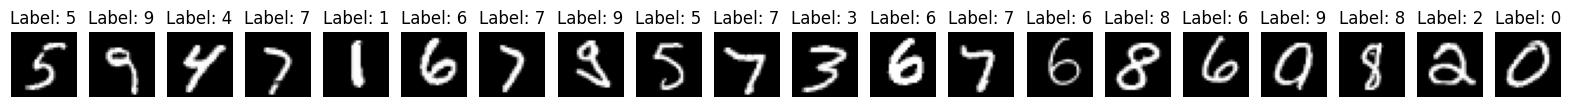

Checking FGSM Dataset:


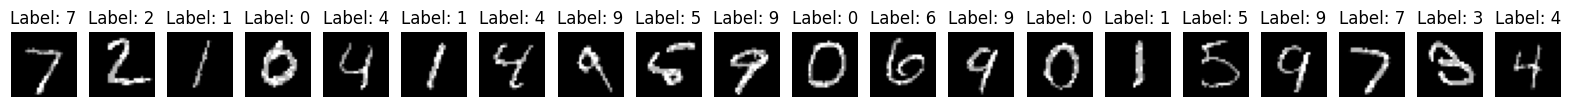

In [18]:
import matplotlib.pyplot as plt

# Function to visualize images and their labels
def check_dataset_images(dataset, num_samples=20):
    plt.figure(figsize=(20, 4))
    for i in range(num_samples):
        image, label = dataset[i]  # Extract image and label
        ax = plt.subplot(4, num_samples, i + 1)
        plt.imshow(image.cpu().squeeze(), cmap="gray")
        ax.set_title(f"Label: {label.item()}")
        ax.axis("off")
    plt.show()

# Check if combined dataset labels are correct
print("Checking Adversarial Dataset:")
check_dataset_images(train_dataset_adversarial)

# Check if FGSM dataset labels are correct
print("Checking FGSM Dataset:")
check_dataset_images(test_dataset_fgsm)

In [19]:
adversarial_model = CNN().to(device)
new_optimizer = optim.Adam(adversarial_model.parameters(), lr=0.0001)
new_criterion = nn.CrossEntropyLoss()

In [20]:
# Function to train the model
def train_model(model, train_loader, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train() # set model in training mode
        train_loss = 0.0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()  # reset gradients
            output = model(data)
            loss = new_criterion(output, target) # compute loss between output and target
            loss.backward()  # calculate gradient per batch of data
            optimizer.step() # update model parameters per batch of data
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss}")

train_model(adversarial_model, train_loader_adversarial, new_optimizer, num_epochs=10)

Epoch 1/10, Training Loss: 0.721437117676618
Epoch 2/10, Training Loss: 0.2378195209670931
Epoch 3/10, Training Loss: 0.16440231244026154
Epoch 4/10, Training Loss: 0.1315618702478564
Epoch 5/10, Training Loss: 0.1119281802006733
Epoch 6/10, Training Loss: 0.09742793576049208
Epoch 7/10, Training Loss: 0.0881430230764692
Epoch 8/10, Training Loss: 0.08020544599251214
Epoch 9/10, Training Loss: 0.07250782740769038
Epoch 10/10, Training Loss: 0.06732670507028397


In [21]:
# accuracy on attacked test dataset with fgsm
test_model(adversarial_model, test_loader_fgsm)


Sample predictions:
Sample 1:
  True label: 7
  Predicted raw output: tensor([ -2.3269,  -0.4539,  -0.0160,   1.0991,  -4.1801,  -2.7184, -11.5594,
         10.1695,  -3.3697,   3.2630], device='cuda:0')
  Predicted label: 7
Sample 2:
  True label: 2
  Predicted raw output: tensor([ 1.5976,  3.9320, 14.1928, -0.3928, -9.6600, -4.8479, -1.8796, -3.5273,
         1.5615, -8.2541], device='cuda:0')
  Predicted label: 2
Sample 3:
  True label: 1
  Predicted raw output: tensor([-1.5166,  7.6537,  0.0118, -3.8530,  0.0373, -2.4997, -0.2051,  0.6640,
        -1.0142, -1.5551], device='cuda:0')
  Predicted label: 1
Sample 4:
  True label: 0
  Predicted raw output: tensor([ 9.2869, -3.6427, -0.2094, -1.7851, -4.6048,  0.2922,  2.8663, -0.9154,
        -3.3294, -2.3495], device='cuda:0')
  Predicted label: 0
Sample 5:
  True label: 4
  Predicted raw output: tensor([-2.8196, -3.4999, -1.1834, -2.2484,  8.2748, -1.9718, -1.7007, -0.9456,
        -1.1805,  4.8714], device='cuda:0')
  Predicted lab

### Approach 2: Variational Auto Encoder (VAE)

In [22]:
# Load and transform the dataset

# Latent space dimension
Z_DIM = 20

vae_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

train_dataset_vae = datasets.MNIST('./data', train=True, transform=vae_transform, download=True)
train_loader_vae = DataLoader(train_dataset_vae, batch_size=BATCH_SIZE, shuffle=True)

test_dataset_vae = datasets.MNIST('./data', train=False, transform=vae_transform, download=True)
test_loader_vae = DataLoader(test_dataset_vae, batch_size=BATCH_SIZE, shuffle=False)

In [23]:
# Define a Variational Auto Encoder Model
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder: Extracts latent features
        self.encoder = nn.Sequential(
            nn.Linear(64 * 64, 512),
            nn.BatchNorm1d(512),  # Batch Norm for stable learning
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),  # Batch Norm
            nn.ReLU()
        )

        # Latent space mapping
        self.fc_mu = nn.Linear(256, Z_DIM)
        self.fc_logvar = nn.Linear(256, Z_DIM)

        # Decoder: Reconstructs images
        self.decoder = nn.Sequential(
            nn.Linear(Z_DIM, 256),
            nn.BatchNorm1d(256),  # Batch Norm in decoder
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 64 * 64),
            nn.Sigmoid()  # Output between 0 and 1
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)  # Convert log variance to std deviation
        eps = torch.randn_like(std)  # Sample Gaussian noise
        return mu + eps * std  # Reparameterization trick

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 64 * 64))
        z = self.reparameterize(mu, logvar) # Sample latent vector
        return self.decode(z), mu, logvar

In [24]:
# Define VAE Loss function
def vae_loss_function(recon_x, x, mu, logvar):
    # Reconstruction loss (BCE for pixel-wise similarity)
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 64 * 64), reduction='sum')
    # KL-Divergence (Regularization)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [25]:
# Train the VAE on clean train MNIST dataset
def train_vae(model, optimizer, data_loader):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(data_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = vae_loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    avg_loss = train_loss / len(data_loader.dataset)
    return avg_loss

In [26]:
# Test the VAE on clean test dataset
def test_vae(model, data_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, _ in data_loader:
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += vae_loss_function(recon_batch, data, mu, logvar).item()
    avg_loss = test_loss / len(data_loader.dataset)
    return avg_loss

In [27]:
vae = VAE().to(device)
vae_optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)

NUM_EPOCHS = 5
for epoch in range(NUM_EPOCHS):
    train_loss = train_vae(vae, vae_optimizer, train_loader_vae)
    test_loss = test_vae(vae, test_loader_vae)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

Epoch 1, Train Loss: 642.3711, Test Loss: 540.3478
Epoch 2, Train Loss: 546.5850, Test Loss: 521.5208
Epoch 3, Train Loss: 534.3707, Test Loss: 515.4681
Epoch 4, Train Loss: 528.1938, Test Loss: 510.5152
Epoch 5, Train Loss: 524.1283, Test Loss: 509.0360


In [28]:
# Reconstruct FGSM attacked images
def reconstruct_fgsm_images(model, data_loader):
    model.eval()
    reconstructed_images = []

    with torch.no_grad():
        for data, _ in data_loader:
            data = transforms.Resize((64, 64))(data).to(device)
            recon_batch, _, _ = model(data)  # Get reconstructed images
            reconstructed_images.append(recon_batch)

    return torch.cat(reconstructed_images)  # Return all reconstructed images

# Pass FGSM-attacked images through VAE to remove noise
reconstructed_images = reconstruct_fgsm_images(vae, test_loader_fgsm)

# Get original labels for FGSM-attacked dataset
test_labels_fgsm = torch.cat([labels for _, labels in test_loader_fgsm])

# Create dataset for CNN evaluation
reconstructed_dataset = TensorDataset(reconstructed_images, test_labels_fgsm)
reconstructed_loader = DataLoader(reconstructed_dataset, batch_size=64, shuffle=False)

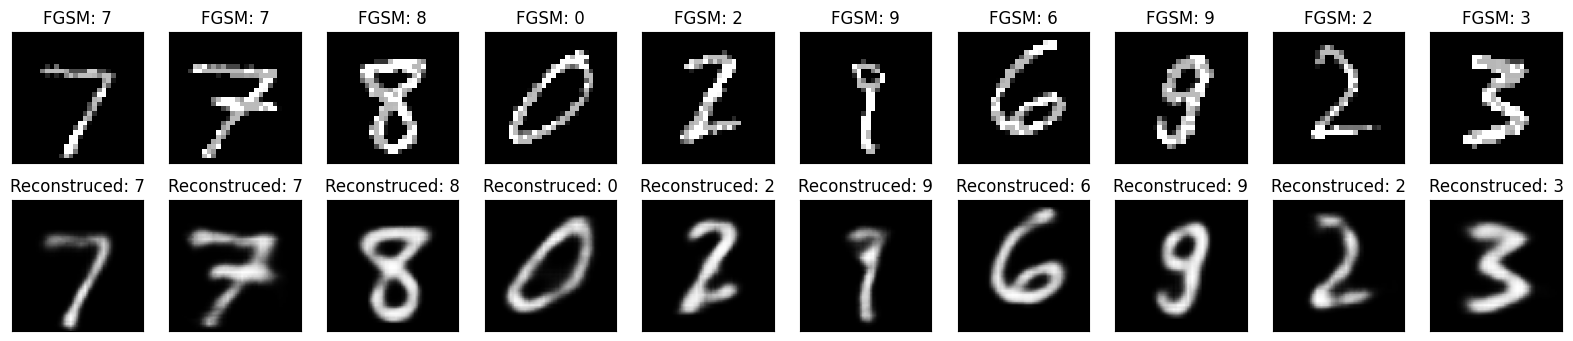

In [29]:
# plot images of both original and reconstructed images
def plot_images(fgsm_dataloader, reconstructed_dataloader, n=10):
    plt.figure(figsize=(20, 4))

    # Get iterators for the DataLoaders
    fgsm_iter = iter(fgsm_dataloader)
    recon_iter = iter(reconstructed_dataloader)

    for i in range(n):
        # Display FGSM noise images
        fgsm_image, fgsm_label = next(fgsm_iter)
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(fgsm_image[0].cpu().squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title(f"FGSM: {fgsm_label[0].item()}")

        # Display reconstructed images
        recon_image, recon_label = next(recon_iter)
        ax = plt.subplot(2, n, i + 1 + n)
        recon_image = recon_image[0].view(64, 64).cpu()  # Reshape the tensor to 64x64
        plt.imshow(recon_image, cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title(f"Reconstruced: {recon_label[0].item()}")
    plt.show()

plot_images(test_loader_fgsm, reconstructed_loader, n=10)

In [32]:
def evaluate_model(model, test_loader, dataset_name="Test"):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Convert flattened images back to (batch, 1, H, W)
            side_length = int(images.shape[1] ** 0.5)  # Auto-detect size
            images = images.view(-1, 1, side_length, side_length)  # Convert back to square image

            # Ensure images are resized to `28x28` if necessary
            images = F.interpolate(images, size=(28, 28), mode="bilinear", align_corners=False)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"{dataset_name} Accuracy: {accuracy:.2f}%")

# Evaluate CNN classifier on VAE-reconstructed FGSM test data
model.load_state_dict(torch.load(model_load_path, weights_only=True))
model.to(device)
evaluate_model(model, reconstructed_loader, "VAE-Reconstructed FGSM Test Dataset")

VAE-Reconstructed FGSM Test Dataset Accuracy: 85.15%


### Approach 3: Generative Adversarial Network (GAN)

In [33]:
# Combine both train and validation dataset together
GAN_train_dataset = ConcatDataset([train_dataset, val_dataset])
GAN_train_loader = DataLoader(GAN_train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [34]:
# Define the GAN (Generator + Discriminator)

# Generator
class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(z_dim, 256),  # transforms the noise vector (z_dim) to a 256-dimensional space
            nn.ReLU(True),
            nn.Linear(256, 512),  #  increase the dimensionality to 512
            nn.ReLU(True),
            nn.Linear(512, 1024),  #  increase the dimensionality to 1024
            nn.ReLU(True),
            nn.Linear(1024, 28 * 28), # outputs a vector of size 28x28
            nn.Tanh()  # Tanh function outputs values in the range [-1, 1], for image data that is normalized to this range
        )

    def forward(self, z):
        return self.model(z).view(z.size(0), 1, 28, 28)  # Reshape to MNIST image

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28 * 28, 1024),
            nn.LeakyReLU(0.2, inplace=True),  # LeakyReLU allows a small gradient for negative inputs
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),  # inplace=True: allows the operation to be done in-place
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()  # Sigmoid function outputs values in the range [0, 1], which can be interpreted as a probability
        )

    def forward(self, img):
        return self.model(img.view(img.size(0), -1)) # reshape to [batch-size, 28*28]



In [35]:
# Initialize models and optimizers
z_dim = 100
generator = Generator(z_dim).to(device)
discriminator = Discriminator().to(device)

optimizer_Gen = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_Disc = optim.Adam(discriminator.parameters(), lr=0.0002)

# Loss function
criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification

epochs = 20

# Training Loop
for epoch in range(epochs):
    for i, (real_images, _) in enumerate(GAN_train_loader):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)

        # Adversarial ground truths: 1 means valid (real) data, 0 means generated (fake) data
        valid_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        ##### Start Train Generator: minimize loss: criterion(discriminator(gen_imgs), valid) #####
        optimizer_Gen.zero_grad()

        # Generate fake images
        z = torch.randn(batch_size, z_dim).to(device)
        gen_images = generator(z)   # generated images generated by Generator

        # Compute generator loss and update
        gen_loss = criterion(discriminator(gen_images), valid_labels)
        gen_loss.backward()
        optimizer_Gen.step()
        ##### End of training the Generator #####

        ##### Start Train Discriminator #####
        optimizer_Disc.zero_grad()

        real_loss = criterion(discriminator(real_images), valid_labels)  # discriminator wants to classify real images as real (valid, i.e., output 1)
        fake_loss = criterion(discriminator(gen_images.detach()), fake_labels) # Detach to avoid training G and classify generated images as fake (i.e., output 0)

        # Compute Discriminator loss and update
        disc_loss = (real_loss + fake_loss) / 2
        disc_loss.backward()
        optimizer_Disc.step()
        ##### End of training the Discriminator #####

        # Print progress
        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] Batch [{i}/{len(GAN_train_loader)}] Loss Disc: {disc_loss.item():.4f}, loss Gen: {gen_loss.item():.4f}")


Epoch [1/20] Batch [0/938] Loss Disc: 0.6792, loss Gen: 0.6997
Epoch [1/20] Batch [100/938] Loss Disc: 0.1225, loss Gen: 1.7279
Epoch [1/20] Batch [200/938] Loss Disc: 0.0397, loss Gen: 2.8187
Epoch [1/20] Batch [300/938] Loss Disc: 2.0034, loss Gen: 2.3981
Epoch [1/20] Batch [400/938] Loss Disc: 0.0178, loss Gen: 3.5202
Epoch [1/20] Batch [500/938] Loss Disc: 0.0083, loss Gen: 4.8291
Epoch [1/20] Batch [600/938] Loss Disc: 0.0400, loss Gen: 3.2003
Epoch [1/20] Batch [700/938] Loss Disc: 0.4514, loss Gen: 1.2418
Epoch [1/20] Batch [800/938] Loss Disc: 0.8104, loss Gen: 0.7583
Epoch [1/20] Batch [900/938] Loss Disc: 0.2122, loss Gen: 1.6316
Epoch [2/20] Batch [0/938] Loss Disc: 0.0544, loss Gen: 2.4980
Epoch [2/20] Batch [100/938] Loss Disc: 0.0000, loss Gen: 12.6626
Epoch [2/20] Batch [200/938] Loss Disc: 0.0242, loss Gen: 5.5336
Epoch [2/20] Batch [300/938] Loss Disc: 0.0378, loss Gen: 7.1587
Epoch [2/20] Batch [400/938] Loss Disc: 0.2341, loss Gen: 5.3330
Epoch [2/20] Batch [500/938]

In [36]:
# Use the Discriminator to Detect FGSM Attacks
def detect_adversarial_samples(discriminator, data_loader):
    discriminator.eval()
    anomaly_scores = []

    with torch.no_grad():
        for images, _ in data_loader:
            images = images.to(device).view(-1, 28 * 28)  # Flatten images
            scores = discriminator(images)  # Get probability score
            anomaly_scores.extend(scores.cpu().numpy())

    return anomaly_scores  # List of probabilities

In [37]:
# Get anomaly scores for adversarial dataset 70% clean and 30% FGSM noise data
anomaly_scores_adversarial = detect_adversarial_samples(discriminator, train_loader_adversarial)

# Get anomaly scores for 100% FGSM attacked test dataset
anomaly_scores_FGSM_data = detect_adversarial_samples(discriminator, test_loader_fgsm)

# Print sample anomaly scores
print("Closer to 0 = More Likely Fake")
print("Sample Anomaly Scores for Adversarail Dataset:")
print([f"{score.item():.4f}" for score in np.array(anomaly_scores_adversarial[:10])])

print("Sample Anomaly Scores for FGSM test dataset:")
print([f"{score.item():.4f}" for score in np.array(anomaly_scores_FGSM_data[:10])])

Closer to 0 = More Likely Fake
Sample Anomaly Scores for Adversarail Dataset:
['0.0000', '1.0000', '1.0000', '1.0000', '0.0002', '0.4283', '0.0000', '0.9952', '0.0000', '1.0000']
Sample Anomaly Scores for FGSM test dataset:
['0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000']


In [40]:
def get_discriminator_accuracy(anomaly_scores, dataset_name):
  # Set threshold (0.5 means anything below it is detected as an anomaly)
  threshold = 0.5
  predicted_labels = [1 if score < threshold else 0 for score in anomaly_scores]  # 1 = Adversarial

  # Compute detection accuracy
  true_labels = [1] * len(predicted_labels)  # All FGSM images are adversarial
  correct = sum(p == t for p, t in zip(predicted_labels, true_labels))
  accuracy = correct / len(predicted_labels) * 100
  print(f"Discriminator Detection Accuracy on {dataset_name}: {accuracy:.2f}%")

In [41]:
# get accuracy for adversarial dataset
get_discriminator_accuracy(anomaly_scores_adversarial, "Adversarial Training Dataset with 30% attacked")

# get accuracy for FGSM test dataset
get_discriminator_accuracy(anomaly_scores_FGSM_data, "FGSM Test Dataset with 100% attacked")


Discriminator Detection Accuracy on Adversarial Training Dataset with 30% attacked: 31.41%
Discriminator Detection Accuracy on FGSM Test Dataset with 100% attacked: 99.49%
